# Собираем данные по студентам из вк

Код очень старый, много костылей. Возможно, что вк ввёл какие-нибудь новые ограничения для парсеоров и код напорется на них. Так произошло с полной выкачкой лайков в пункте 7. Из-за этого пришлось дописать пункт 8 с проверкой вместо выкачки. 

In [50]:
# Загружаем необходимые библиотеки
import datetime                  # Пакет для работы с временными форматами
import pickle                    # Пакет для подгрузки данных специфического для питона формата
import re                        # Пакет для регулярок
import requests                  # Пакет для скачки данных из этих ваших интернетов
import pandas as pd              # Пакет для работы с таблицами
import numpy as np               # Пакет для работы с векторами и матрицами
import matplotlib.pyplot as plt  # Пакет для строительства графиков
import time            # Пакет для работы со временем. Например, помогает ставить заглушки 
                       # time.sleep(секунды), необходимые для того что ВК не банил нащего
                       # сборщика данных из-за слишком частых запросов
        
# Пакет для красивых циклов. При желании его можно отключить. Тогда из всех циклов придётся 
# удалять команду tqdm_notebook.
from tqdm import tqdm as tqdm_notebook   # подробнее: https://github.com/tqdm/tqdm

In [51]:
# мой номер странички
my_user_id = 91857120
# версия используемого API
version = '5.103'
# подгружаем токен
with open('/Users/fulyankin/Desktop/token') as f:
    token = f.read()

In [52]:
def vk_download(method, parameters, token=token, version=version):
    """
        Возвращает результат запроса по методу
        
        method: string
            метод из документации, который хотим использовать
            
        parameters: string
            параметры используемого метода
            
        token: string
            токен Oauth доступа
        
        version: string
            версия API
    """
    
    # составляем ссылку
    url = 'https://api.vk.com/method/{method}?{parameters}&access_token={token}&v={version}'
    url = url.format(method=method, parameters=parameters, token=token, version=version)
    # запрашиваем ссылку и переводим в json (словарь)
    response = requests.get(url).json()
    return response

vk_download('users.get','user_ids=ppilif')

{'response': [{'id': 6045249,
   'first_name': 'Филипп',
   'last_name': 'Ульянкин',
   'is_closed': False,
   'can_access_closed': True}]}

## 1.  Собираем базовую инфу по страницам

In [4]:
def load_ids(path):
    ids = [ ]  # Подгружаю айдишники с компа 

    # read ids 
    with open(path) as f:
        for item in f.readlines():
            ids.append(item)

    # Вытащили айдишники из той мерзости, которую собрала студентота 
    ids = sorted(set([re.sub('https://|http://|vk.com/|m.vk.com/|\n|\t', '', item) for item in ids]))
    return ids

ids_bmm = load_ids('../../../nda/email_vk_2019/bmm_ids')
ids_bmb = load_ids('../../../nda/email_vk_2019/bmb_ids')

ids = ids_bmm + ids_bmb

In [5]:
# Постучались в каждый айдишник и запомнили только тех, кто не битый
# Всех битых, если возможно, исправляем вручную
all_uids = [ ]
err_uids = [ ]

In [6]:
for item in tqdm_notebook(ids):
    time.sleep(0.3)
    try:
        rq = vk_download('users.get','user_ids={}'.format(item))['response']
        all_uids.append(item)
    except:
        err_uids.append(item)

len(err_uids), len(all_uids) 

100%|██████████| 427/427 [03:23<00:00,  2.10it/s]


(0, 427)

In [7]:
err_uids

[]

## 2. Качаю профили 

Внимательно поизучаем то какие именно штуки можно выгрузить по каждой страничке [в документации](https://vk.com/dev/objects/user) и поделим всё это чуда на пять разных категорий. После будем скачивать данные по каждой категории и работать с ними. Код будет убойным, но мы так хотябы не сойдём с ума.

In [8]:
# Основные параметры
first_par = ['bdate','city','home_town','relation', 'sex']

# Есть ли возможность получить данные (например, открыты ли комменты или аудио)
availible_functions = ['can_post','can_see_all_posts','can_see_audio','can_write_private_message','has_mobile', \
                       'has_photo','wall_comments']
# Вторичные параметры
second_par = ['about','activities','books','connections','contacts','country','education','exports',\
                    'followers_count', 'games', 'interests', 'movies','music','quotes', 'site', 'tv']

# Важные списки
first_spisok = ['counters','personal','last_seen']

# Вторичные списки
second_spisok = ['schools', 'universities', 'occupation', 'relatives']

# для сбора в список 
parametr_creator = lambda lst: ','.join(lst)


# Говноциклы для скачки
# Создаём свой инфа вектор для каждого рода информации

profile_first = [ ]
profile_second = [ ]
profile_availible = [ ]
profile_first_spisok = [ ]
profile_second_spisok = [ ]

spiski = [first_par, second_par, availible_functions, first_spisok, second_spisok]
infa = [profile_first, profile_second, profile_availible, profile_first_spisok, profile_second_spisok]

# Первый цикл идёт по всем юзерам из списка. Второй цикл идёт по парам (название параметра, вектор для записи)
# В итоге на выходе получаем заполненные вектора из вектора spisok. 

# На случай, если красивая строка для цикла вдруг не работает 
# Надо установить виджет отсюда:  https://ipywidgets.readthedocs.io/en/stable/user_install.html

for user in tqdm_notebook(all_uids):
    for a, b in zip(spiski,infa):
        time.sleep(0.4) # Временная заглушка
        we_want = parametr_creator(a) # Превращаем вектор в текст
        current = vk_download('users.get','user_ids='+str(user)+'&fields='+we_want)
        b.append(current)

100%|██████████| 427/427 [20:48<00:00,  2.92s/it]


Распаковываем всё накачаное добро в табличку. 

In [9]:
# Создаём таблицу, в которую мы запишем все созданные фичи
df_profile = pd.DataFrame()      

### Первый кусок информации 

In [10]:
infa[0][0]['response']

[{'id': 182152789,
  'first_name': 'Александра',
  'last_name': 'Абашкова',
  'is_closed': False,
  'can_access_closed': True,
  'sex': 1,
  'bdate': '14.5',
  'city': {'id': 1, 'title': 'Москва'},
  'home_town': 'Москва',
  'relation': 0}]

In [11]:
# Очистим данные от респонсов.
inf_1 = [item['response'][0] for item in infa[0]]
df_1 = pd.DataFrame(inf_1)

# на случай если у нас есть все странички
#df_1['deactivated'] = None

# 0. Не трогаем 
df_profile['uid'] = df_1['id']
df_profile['first_name'] = df_1['first_name']
df_profile['last_name'] = df_1['last_name']
df_profile['is_closed'] = df_1['is_closed']

# 1. Заменим в колонке deactivated все пропуски на нули
df_profile['deactivated_dummy'] = df_1.deactivated
df_profile['deactivated_dummy'].fillna(0,inplace=True)

# 2. Названия городов! 
df_profile['city'] = df_1.city.apply(lambda w: np.nan if w is np.nan else  w['title'])

# Тут же запишем указанный родной город 
df_profile['home_town'] = df_1['home_town']

# 3. Создаэм дамми-переменную 'Мужчина'
df_profile['male_dummy'] = df_1['sex'] - 1 

# 4. Создаём колонку с семейным положением. 
df_profile['relation_cat'] = df_1['relation'].replace({
    1 : 'не женат/не замужем',
    2 : 'есть друг/есть подруга',
    3 : 'помолвлен/помолвлена',
    4 : 'женат/замужем',
    5 : 'всё сложно',
    6 : 'в активном поиске',
    7 : 'влюблён/влюблена',
    8 : 'в гражданском браке',
    0 : 'не указано' })

df_profile['relation_partner'] = df_1['relation_partner']

# 5. Разобьём колонку Дата рождения на колонку год, месяц, день рождения. 
def get_generate(item, coord):
    def get(item):
        potential = item.split('.')
        if len(potential[-1]) == 4:
            return potential[coord]
        else:
            return None 
    return get

get_year = get_generate(item, -1)
get_month = get_generate(item, -2)
get_day = get_generate(item, -3)

df_profile['byear'] = df_1.bdate.apply(lambda w: np.nan if w is np.nan else  get_year(w))
df_profile['bmonth'] = df_1.bdate.apply(lambda w: np.nan if w is np.nan else  get_year(w))
df_profile['bday'] = df_1.bdate.apply(lambda w: np.nan if w is np.nan else  get_year(w))

### Второй кусок информации

In [12]:
infa[1][0]

{'response': [{'id': 182152789,
   'first_name': 'Александра',
   'last_name': 'Абашкова',
   'is_closed': False,
   'can_access_closed': True,
   'country': {'id': 1, 'title': 'Россия'},
   'home_phone': '',
   'instagram': '_sashka_ab',
   'site': '',
   'followers_count': 251,
   'university': 128,
   'university_name': 'НИУ ВШЭ (ГУ-ВШЭ)',
   'faculty': 0,
   'faculty_name': '',
   'graduation': 0,
   'interests': '',
   'music': '',
   'activities': '',
   'movies': '',
   'tv': '',
   'books': '',
   'games': '',
   'about': '',
   'quotes': ''}]}

In [13]:
inf_2 = [item['response'][0] for item in infa[1]] # Очистим данные от респонсов.
df_2 = pd.DataFrame(inf_2)                        # Создаём черновую табличку 

# 1. Разбираемся со странами также как с городами 
df_profile['country'] = df_2.country.apply(lambda w: np.nan if w is np.nan else  w['title'])

# 2. Преобразуем все колонки с отсылками в другие сети в то, что в них что-то указано
def social_replace(df, colname):
    # Везде, где нет None или незаполненной ячейки, ставлю 1
    df.loc[(df[colname].isnull() == False)&(df[colname] != ''), colname] = 1 
    # Все None и пустоты меняем на нули 
    df.loc[(df[colname].isnull() == True)|(df[colname] == ''), colname] = 0
    return df[colname]

# костыли для полей, которых не оказалось
#df_2['facebook'] = None 

# распаковка
df_profile['facebook_dummy'] = social_replace(df_2,'facebook')
df_profile['instagram_dummy'] =social_replace(df_2,'instagram')
df_profile['skype_dummy'] = social_replace(df_2,'skype')
df_profile['twitter_dummy'] = social_replace(df_2,'twitter')
df_profile['home_phone_dummy'] = social_replace(df_2,'home_phone')
df_profile['mobile_phone_dummy'] = social_replace(df_2,'mobile_phone')
df_profile['site_dummy'] = social_replace(df_2,'site')

# 3. Перекидывем хорошие колонки в нашу итоговую табличку  
df_profile['folowers_cnt'] = df_2['followers_count']   
df_profile['university_str'] = df_2['university_name']
df_profile['faculty_str'] = df_2['faculty_name']

# 4. Текстовые поля со страницы
df_profile['about_str'] = df_2['about']
df_profile['activities_str'] = df_2['activities']
df_profile['books_str'] = df_2['books']
df_profile['interests_str'] = df_2['interests']
df_profile['movies_str'] = df_2['movies']
df_profile['music_str'] = df_2['music']
df_profile['quotes_str'] = df_2['quotes']
df_profile['tv_str'] = df_2['tv']
df_profile['games_str'] = df_2['games']

### Третий кусок

In [14]:
infa[2][0]

{'response': [{'id': 182152789,
   'first_name': 'Александра',
   'last_name': 'Абашкова',
   'is_closed': False,
   'can_access_closed': True,
   'has_photo': 1,
   'has_mobile': 1,
   'wall_comments': 1,
   'can_post': 0,
   'can_see_all_posts': 0,
   'can_see_audio': 0,
   'can_write_private_message': 1}]}

In [15]:
# Очистим данные от респонсов.
inf_3 = [item['response'][0] for item in infa[2]]
df_3 = pd.DataFrame(inf_3)

# Открыта ли для моих записей стена пользователя 
df_profile['can_post_dummy'] = df_3.can_post

# Открыты ли для просмотра мной стена пользователя
df_profile['can_see_all_posts_dummy'] = df_3.can_see_all_posts

# Открыты ли для меня аудио пользователя
df_profile['can_see_audio_dummy'] = df_3.can_see_audio

# Могу ли я писать пользователю сообщения
df_profile['can_write_private_message_dummy'] = df_3.can_write_private_message

# Известен ли вк мобильник пользователя
df_profile['has_mobile_dummy'] = df_3.has_mobile

# Есть ли у пользоваетеля ава 
df_profile['has_ava_dummy'] = df_3.has_photo

# Включены ли на стене комментарии 
df_profile['wall_comments_dummy'] = df_3.wall_comments

### Четвёртый кусок 

In [16]:
infa[3][0]

{'response': [{'id': 182152789,
   'first_name': 'Александра',
   'last_name': 'Абашкова',
   'is_closed': False,
   'can_access_closed': True,
   'last_seen': {'time': 1577886295, 'platform': 2},
   'counters': {'albums': 0,
    'videos': 19,
    'audios': 0,
    'photos': 3,
    'friends': 298,
    'online_friends': 62,
    'mutual_friends': 3,
    'followers': 251,
    'subscriptions': 2,
    'pages': 165},
   'personal': {'langs': ['Русский', 'English', 'Français'],
    'religion_id': 0}}]}

In [17]:
# Очистим данные от респонсов.
inf_4 = [item['response'][0] for item in infa[3]]
df_4 = pd.DataFrame(inf_4)

# 1. Распаковываем счётчики в отдельный датафрейм 
df_counters = pd.DataFrame(list(df_4.counters.apply(lambda w: {'albums':  np.nan} 
                                                        if w is np.nan else w).values))

df_profile['albums_cnt'] = df_counters.albums
df_profile['audio_cnt'] = df_counters.audios
df_profile['followers_cnt'] = df_counters.followers
df_profile['friends_cnt'] = df_counters.friends
df_profile['gifts_cnt'] = df_counters.gifts
df_profile['groups_cnt'] = df_counters.groups
df_profile['mutual_friends_cnt'] = df_counters.mutual_friends
# df_profile['notes_cnt'] = df_counters.notes
df_profile['photos_cnt'] = df_counters.photos
df_profile['subscriptions_cnt'] = df_counters.subscriptions
df_profile['user_photos_cnt'] = df_counters.user_photos
df_profile['videos_cnt'] = df_counters.videos
df_profile['pages_cnt'] = df_counters.pages

# 2. Точно также распоковываем персональную информацию
df_personal = pd.DataFrame(list(df_4.personal.apply(lambda w: {'political' :  np.nan} 
                                                        if w is np.nan else w).values))

# Расшифровываем все категориальный фичи, связанные с политикой и алкоголем
# Алкогольная и сигаретная фичи, это оценки по шкале от 1 до 5. Они разумно упорядочены, не будем их менять
df_profile['alco_love_cat'] = df_personal.alcohol
df_profile['smoke_love_cat'] = df_personal.smoking

# Колонки религия и источники вдохновения заполняются людьми самостоятельно и сильно разряжены
df_profile['religion_str'] = df_personal.religion
df_profile['inspired_by_str'] = df_personal.inspired_by

# Главное в жизни, политические взгляды и главное в людях раскодируем в текст
df_profile['life_main_cat'] = df_personal.life_main.replace({
    1 : 'семья и дети',
    2 : 'карьера и деньги',
    3 : 'развлечения и отдых',
    4 : 'наука и исследования',
    5 : 'совершенствование мира',
    6 : 'саморазвитие',
    7 : 'красота и искусство',
    8 : 'слава и влияние'
    })

df_profile['people_main_cat'] = df_personal.people_main.replace({
    1 : 'ум и креативность',
    2 : 'доброта и честность',
    3 : 'красота и здоровье',
    4 : 'власть и богатство',
    5 : 'смелость и упорство',
    6 : 'юмор и жизнелюбие' 
    })

df_profile['political_cat'] = df_personal.political.replace({
    1 : 'коммунистические',
    2 : 'социалистические',
    3 : 'умеренные',
    4 : 'либеральные',
    5 : 'консервативные',
    6 : 'монархические',
    7 : 'ультраконсервативные',
    8 : 'индифферентные',
    9 : 'либертарианские'    
    })

# число языков, указанное в профиле 
df_profile['lang_cnt'] = df_personal.langs.apply(lambda w: np.nan if w is np.nan else len(w))
df_profile['english_dummy'] = df_personal.langs.apply(lambda w: np.nan if w is np.nan else int('English' in w))

### Пятый кусок 

In [18]:
infa[4][0]

{'response': [{'id': 182152789,
   'first_name': 'Александра',
   'last_name': 'Абашкова',
   'is_closed': False,
   'can_access_closed': True,
   'occupation': {'type': 'university', 'id': 128, 'name': 'НИУ ВШЭ (ГУ-ВШЭ)'},
   'universities': [{'id': 128,
     'country': 1,
     'city': 1,
     'name': 'НИУ ВШЭ (ГУ-ВШЭ)'}],
   'schools': [{'id': '1724839',
     'country': 1,
     'city': 1,
     'name': 'Лицей НИУ ВШЭ',
     'class': '',
     'type': 2,
     'type_str': 'Лицей'}],
   'relatives': [{'id': -703011362, 'type': 'sibling', 'name': 'Ваня Егор'}]}]}

In [19]:
# Очистим данные от респонсов.
inf_5 = [item['response'][0] for item in infa[4]]

# Не хочу думать => говнокод
# В этот вектор будем помещать наши словарики 
dct_inf_5 = [ ]

for jtem in inf_5: 
    dct_5 = { }
    dct_5.update({'id' : jtem['id']})  # Добавляем id
    # Разбираемся со школами:
    try:  # Пробуем найти в списке школу.  Если получилось, заполняем информацию
        item = jtem['schools']
        if len(item) == 0:
            dct_5.update({'schools_count' : np.nan,
                           'last_bukva_class' : np.nan,
                           'change_city_school' : np.nan                          
                          })
        else:
            cts = set([it['city'] for it in item])
            dct_5.update({'schools_count' : len(item),
                            'last_bukva_class' : item[-1]['class'],
                            'change_city_school' : len(cts)  
                            })
    except: # Если не получилось, записываем пропуски. Не получится у людей, удаливших странички. 
        dct_5.update({'schools_count' : np.nan,
                       'last_bukva_class' : np.nan,
                        'change_city_school' : np.nan                          
                        })
    # Записываем новый элемент в вектор
    dct_inf_5.append(dct_5)   
    
df_5 = pd.DataFrame(dct_inf_5)
df_5.columns = ['profile_change_city_school_cnt', 'profile_last_bukva_class_str',
                'profile_schools_cnt', 'uid']

df_profile['change_city_school_cnt'] = df_5['profile_change_city_school_cnt']
df_profile['last_bukva_class_str'] = df_5['profile_last_bukva_class_str']
df_profile['schools_cnt'] = df_5['profile_schools_cnt']

In [20]:
print(df_profile.shape)
df_profile.head( )

(427, 64)


,uid,first_name,last_name,is_closed,deactivated_dummy,city,home_town,male_dummy,relation_cat,relation_partner,...,religion_str,inspired_by_str,life_main_cat,people_main_cat,political_cat,lang_cnt,english_dummy,change_city_school_cnt,last_bukva_class_str,schools_cnt
0,182152789,Александра,Абашкова,False,0,Москва,Москва,0,не указано,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0,182152789,
1,148020433,Анастасия,Чуфистова,False,0,Рязань,Рязань,0,не указано,NaN,...,NaN,NaN,0,0,NaN,1.0,0.0,1.0,148020433,а
2,138413935,Александр,Головачев,False,0,Москва,Омск,1,не женат/не замужем,NaN,...,NaN,NaN,саморазвитие,ум и креативность,умеренные,2.0,1.0,NaN,138413935,NaN
3,366261055,Анна,Лобанова,False,0,NaN,,0,не указано,NaN,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,366261055,NaN
4,111252392,Алексей,Пузырный,False,0,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111252392,NaN


Всех, кто деактивирован - нафиг! 

In [21]:
df_profile = df_profile[df_profile.deactivated_dummy == 0]
df_profile.drop('deactivated_dummy', axis=1, inplace = True)

In [22]:
df_profile.shape

(426, 63)

In [23]:
df_profile['is_bmm'] = df_profile.uid.apply(lambda w: w in ids_bmm)

In [24]:
df_profile.to_csv('vk_data_profile.csv', sep='\t')

## 3. Взаимосвязи (кто у кого в друзьях) 

Некоторые профили приватные либо скрыли друзей, будем помечать таких меткой. 

In [25]:
friends_dict = { }
priv_cnt = 0

all_uids = df_profile.uid.values

for user in tqdm_notebook(all_uids):
    time.sleep(0.4)
    try:
        s = vk_download('friends.get','user_id='+str(user))['response']
        
        # В итоговый словарик включаем id только людей из списка, всех левых в топку 
        friends_dict[user] = [item for item in s['items'] if item in all_uids]
    except:
        friends_dict[user] = ['private_profile']
        priv_cnt += 1
    
priv_cnt

100%|██████████| 426/426 [03:57<00:00,  1.79it/s]


41

In [26]:
with open('vk_data_friends', 'wb') as f:
    pickle.dump(friends_dict, f)

## 4. Интересные страницы 

Интересные страницы всех юзеров 

In [27]:
publics_dict = { }
priv_cnt = 0

all_uids = df_profile.uid.values

for user in tqdm_notebook(all_uids):
    time.sleep(0.4)
    try:
        s = vk_download('users.getSubscriptions','user_id='+str(user))['response'] 
        publics_dict[user] = s['groups']['items']
    except:
        publics_dict[user] = ['private_profile']
        priv_cnt += 1
    
priv_cnt

100%|██████████| 426/426 [04:08<00:00,  1.71it/s]


41

In [28]:
with open('vk_data_publ', 'wb') as f:
    pickle.dump(publics_dict, f)

## 5. Стены

Ещё немного говнокода для скачки всякого разного 

In [29]:
def Get_Wall(this_id):
    
    # Сколько у пользователя на стене записей...
    n = vk_download('wall.get','owner_id=' + str(this_id))['response']['count']
    time.sleep(0.4) 
    
    chto_on_postit = [ ]
    for i in range(0,100*(n//100+1),100):
        time.sleep(0.4) 
        
        wall = vk_download('wall.get', 'owner_id=' + str(this_id) +'&count=100&offset='+str(i))['response']['items']
        
        chto_on_postit.extend(wall)

    # варим по стене фичи 
    wi = { } # aka wall information 
    
    # Проходимся по информации из всех записей и собираем самое важное в фичи 
    for item in chto_on_postit:
        new_pos = [ ]
        # Поработаем с датой чуть более подробно. Преобразуем дату в удобочитаемый формат.
        real_data = datetime.datetime.fromtimestamp(item['date'])  
        new_pos.append(real_data)    # когда сделана запись
        new_pos.append(real_data.year)  # выделим год, когда сделана запись 
        new_pos.append(real_data.month) # выделим месяц
        new_pos.append(real_data.day)   # день, когда сделан пост
        new_pos.append(real_data.hour)  # час, когда сделан пост 
        
        # Нормальная дата для фичи "Когда сделан репостнутый пост"
        try:
            new_pos.append(datetime.datetime.fromtimestamp(item['copy_post_date']))
        except:
            new_pos.append(None)        
        
        new_pos.append(item['post_type'])             # тип записи post, copy, reply, postpone, suggest.
        new_pos.append(item['from_id'])               # кто оставил запись 
        new_pos.append(item['text'])                  # контент записи 
        new_pos.append(item['likes']['count'])        # число лайков 
        new_pos.append(item['reposts']['count'])      # число репостов 
        new_pos.append(item['comments']['count'])     # число комментов 
        new_pos.append(item['comments']['can_post'])  # можно ли оставлять комменты 
       
        # просмотры (если запись не старая), пропуск, если запись старая 
        try:
            new_pos.append(item['views']['count'])
        except:
            new_pos.append(None)
            
        # Истиный владелец записи (если это репост или запись оставлена)
        try:
            new_pos.append(item['copy_owner_id'])
        except:
            new_pos.append(None)   
            
        # Подробнее: https://vk.com/dev/objects/post_source
        # Через что создана запись 
        try:
            new_pos.append(item['post_source']['type'])
        except:
            new_pos.append(None)        
        
        # С какой платформы создана запись, если это телефон 
        try:
            new_pos.append(item['post_source']['platform'])
        except:
            new_pos.append(None)        
        
        # Дополнительный контент у поста
        try:
            new_pos.append([jtem['type'] for jtem in item['attachments']])
        except:
            new_pos.append(None)        
        # Сохраняям в словарик, ключ - id записи 
        wi[item['id']] = new_pos
        
    # превращаем всё, что насобирали в таблицу
    df = pd.DataFrame(wi).T
    df.columns = ['date', 'year', 'month', 'day','hour', 'copy_post_date', 'post_type', 'from_id', 'text', 
          'likes', 'reposts', 'comments', 'can_comment', 'views', 'copy_owner_id', 'type', 
          'platform', 'attachments']
    # добавляем столбец с id юзера
    df['uid'] = df.shape[0]*[this_id]
    return df


# Варим фичи :) 
def feature_extract(df, cur_id):
    fd = { }
    fd['wall_post_cnt'] = df.shape[0]  # Всего записей на стене 
    
    # Фичи по колокам из типов постов и откуда сделаны посты 
    fd['wall_post_original_cnt'] = sum((df.post_type == 'post')&(df.from_id == cur_id)) # свои посты 
    fd['wall_post_other_cnt'] = sum((df.post_type == 'post')&(df.from_id != cur_id))    # чужие посты
    fd['wall_repost_group_cnt'] = sum((df.post_type == 'copy')&(df.copy_owner_id < 0))  # число репостов групп
    fd['wall_repost_user_cnt'] = sum((df.post_type == 'copy')&(df.copy_owner_id > 0))   # число репостов юзеров
    fd['wall_post_reply_cnt'] = sum(df.post_type == 'reply')        # ответы на своей стене на чужие записи

    # id тех, кого репостим (надо для детекции мусорных групп)
    # fd['wall_repost_people_id'] = list(set(df.copy_owner_id[df.copy_owner_id > 0])) # люди
    # fd['wall_repost_groups_id'] = list(set(df.copy_owner_id[df.copy_owner_id < 0])) # групры

    # Лайки, просмотры и тп
    fd['wall_like_cnt'] = df.likes.sum()                  # всего на стене лайков
    fd['wall_like_max'] = df.likes.max()                  # максимальное число лайков
    fd['wall_like_mean'] = df.likes.mean()                # среднее число лайков
    fd['wall_like_median'] = df.likes.median()            # медианное число лайков 

    fd['wall_repost_cnt'] = df.reposts.sum()              # всего репостов за стену 
    fd['wall_repost_max'] = df.reposts.max()              # максимальное число репостов
    fd['wall_repost_mean'] = df.reposts.mean()            # среднее число репостов
    fd['wall_repost_median'] = df.reposts.median()        # медианное число репостов

    fd['wall_can_comment'] = df.can_comment.get_values()[0] # можно ли коментить стенку 
    fd['wall_comment_cnt'] = df.comments.sum()            # всего комментов за стену 
    fd['wall_comment_max'] = df.comments.max()            # максимальное число коментов
    fd['wall_comment_mean'] = df.comments.mean()          # среднее число коментов
    fd['wall_comment_median'] = df.comments.median()      # медианное число коментов

    # Тип источника 
    fd['wall_post_instagram_cnt'] = sum((df.type == 'api')&(df.platform == 'instagram')) # посты из инстаграма
    fd['wall_post_android_cnt'] = sum((df.type == 'api')&(df.platform == 'android'))     # посты из андроида
    fd['wall_post_iphone_cnt'] = sum((df.type == 'api')&(df.platform == 'iphone'))       # посты с айфона
    fd['wall_post_ipad_cnt'] = sum((df.type == 'api')&(df.platform == 'ipad'))           # посты с апада
    fd['wall_post_wphone_cnt'] = sum((df.type == 'api')&(df.platform == 'wphone'))  # преступление против человечества

    # fd['wall_post_web_cnt'] = sum(df.type == 'vk')          # запись через браузер 
    # fd['wall_post_mweb_cnt'] = sum(df.type == 'mvk')        # запись через мобильный браузер 
    # fd['wall_post_widget'] = sum(df.type == 'widget')  # запись создана через виджет на стороннем сайте обычно 
                                                       # это комменты с других сайтов где ты авторизован через вк
    # Немного информации по текстам записей 
    texts_len = [len(item) for item in df.text]
    fd['wall_text_len_cnt'] = np.sum(texts_len)            # суммарно символов на стене
    fd['wall_text_len_max'] = np.max(texts_len)            # максимально символов в посте
    fd['wall_text_len_mean'] = np.mean(texts_len)          # среднее число символов в посте
    fd['wall_text_len_median'] = np.median(texts_len)      # медианное число символов в посте 

    # Эмодзи-анализ записей 
    # Выбрасываем из записи все символы, кроме эмодзи и редких символов вроде иероглифов
    emoji = [re.sub('[a-яa-zA-ZА-Я -.,0-9<>:=;/_—@$^?–ё`%#*&!№…\|/\"\]\[\"\'\n\t”“’‘]','',item) for item in df.text]
    count_emoji = [len(item) for item in emoji]      # вычисляем эмодзи-след
    fd['wall_emoji_cnt'] = np.sum(count_emoji)       # суммарно эмодзи на стене 
    fd['wall_emoji_max'] = np.max(count_emoji)       # максимально эмодзи в посте
    fd['wall_emoji_mean'] = np.mean(count_emoji)     # среднее число эмодзи на стене 
    fd['wall_emoji_median'] = np.median(count_emoji) # медианное число эмодзи на стене 
    fd['wall_emoji_trace'] = ''.join(emoji)          # эмодзи-след человека
    fd['wall_text'] = ' '.join(df.text)              # весь текст целиком (надо для кластеров)

    # Дополнительный контент под постом 
    # Подробнее про контент https://vk.com/dev/objects/attachments_w
    # content = ['photo', 'posted_photo', 'video', 'audio', 'doc', 'graffiti', 'link', 'note',
    #           'app', 'poll', 'page', 'album', 'photos_list', 'market', 'market_album', 'sticker']

    # Посчитаем по каждому типу вложений такие же метрики как выше и добавим в итоговый словарик
#     def content_count(content_name):
#         counter = [ ]
#         for item in df.attachments:
#             counter.append(np.sum(np.array(item) == content_name))
#         return np.sum(counter), np.max(counter), np.mean(counter), np.median(counter)

#     for cont in content:
#         fd['wall_' + cont + '_cnt'], fd['wall_' + cont + '_max'], fd['wall_' + cont + '_mean'],\
#                fd['wall_' + cont + '_median'] = content_count(cont)

    # Можно сделать ещё фич на основе времени, но лениво 
    fd['wall_year_mean'] = np.mean([sum(df.year == item) for item in set(df.year)])     # В среднем за год постов 
    fd['wall_month_mean'] = np.mean([sum(df.month == item) for item in set(df.month)]) # В среднем за месяц постов 

    # Сколько времени проходит между тем как автор сделал пост и человек это репостнул 
    df_copy = df[df.post_type == 'copy']
    slow = [ss.seconds/3600 for ss in  df_copy.date - df_copy.copy_post_date if ss.days < 500]
    # Условие < 500 нужно, чтобы отсеять выбросы. Иногда дата стоит некоректно 
    if len(slow) > 0:
        fd['wall_slowpok_hour_median'] = np.median(slow)
        fd['wall_slowpok_hour_max'] = np.max(slow)
    else:
        fd['wall_slowpok_hour_median'] = 0 
        fd['wall_slowpok_hour_max'] = 0
        
    fd['uid'] = df.uid.get_values()[0]
    return fd     

In [30]:
wall_infa = { }      # Табличка с информацией по стенкам 
k = 0                # Счётчик для выяснения сколько страниц удалены 
l = 1                # Индекс для таблички 

for uid in tqdm_notebook(all_uids):
    l += 1
    time.sleep(0.4) # И пусть весь мир подождёт! 
    try:
        df = Get_Wall(uid)
        wall_infa[l] =  feature_extract(df, uid)
    except:
        wall_infa[l] = {'uid': uid} # пустоты 
        k += 1
        
print(k)

100%|██████████| 426/426 [31:20<00:00,  4.41s/it]  

79


In [31]:
df_wall = pd.DataFrame(wall_infa).T
print(df_wall.shape)
df_wall.head()

(426, 39)


,uid,wall_can_comment,wall_comment_cnt,wall_comment_max,wall_comment_mean,wall_comment_median,wall_emoji_cnt,wall_emoji_max,wall_emoji_mean,wall_emoji_median,...,wall_repost_median,wall_repost_user_cnt,wall_slowpok_hour_max,wall_slowpok_hour_median,wall_text,wall_text_len_cnt,wall_text_len_max,wall_text_len_mean,wall_text_len_median,wall_year_mean
2,182152789,0,17,4,0.53125,0,0,0,0,0,...,0,0,0,0,Давай поговорим о личном Буду вашим кото...,188,69,5.875,0,6.4
3,148020433,0,397,18,0.307038,0,1975,437,1.52746,0,...,0,0,0,0,"Лучший фотограф😻😻 ой, может даже у...",103157,1529,79.7811,39,143.667
4,138413935,0,0,0,0,0,3,2,1.5,1.5,...,1.5,0,0,0,"🚀 [id18115779|Баха], спасибо за атмосферу 🌌 \n...",83,82,41.5,41.5,1
5,366261055,0,0,0,0,0,63,38,3.5,0,...,0,0,0,0,Не проходите мимо! Приходите к нам! Ждём всех!...,5593,4928,310.722,0,4.5
6,111252392,0,43,11,1.19444,0,11,4,0.305556,0,...,0,0,0,0,"Нам пора признать, что зимний сезон следует сд...",2681,711,74.4722,23,7.2


In [32]:
df_wall.to_csv('vk_data_wall.csv',sep='\t')

## 6. Фотки 

In [33]:
# Функция для конкретного id собирает фоточки пользователя и выдает их в грязном виде
# и в виде таблицы с основной информацией о постах. Также на выход выдаётся словарь из ссылок на фотки,
# в котором ключами являются id фоток 

# Функция будет пытаться добавить в вектор из контактовского ответа 
# новый элемент, если его там нет, то добавит None 
def tr_ex(add, out, name):
    try:
        add.append(out[name])
    except:
        add.append(None)

# То же самое, но для двууровнегого словоря 
# (знаю, звучит сложно, но это не так)
def tr_ex2(add, out, name1, name2):
    try:
        add.append(out[name1][name2])
    except:
        add.append(None)
        

def Get_Photo(this_id):
    # Делай раз! Выясним сколько у пользователя фоток...
    n = vk_download('photos.getAll','owner_id='+ str(this_id))['response']['count']
    time.sleep(0.4) # Сразу же после этого немного подождём
    
    # Качаем все фотки из альбомов!
    chto_on_fotkaet = [ ]
    for i in range(0,100*(n//100+1),100):
        #Качаем внеочередные 100 фоточек
        time.sleep(0.4) # Не забываем немного подождать перед каждой итераций
        photos = vk_download('photos.getAll','owner_id='+ str(this_id) +'&no_service_albums=0&extended=1'+\
                               '&count=100&offset='+str(i))['response']['items']
        # Первый ээлемент всегда число фоток, игнорируем его
        chto_on_fotkaet.extend(photos)
        
    # В файлике chto_on_fotkaet будут лежать грязные фотки.
    # Сразу же сварим важные фичи и запихнём их в табличку  
    # Подробнее: https://vk.com/dev/objects/photo
    phi = { } # aka photo information 
    
    # Проходимся по информации из всех фоток и забираем информацию
    for item in chto_on_fotkaet:
        new_ph = [ ]   # Вектор для наблюдений 
        
        # Делай раз! Дата. Преобразуем её в читаемый вид 
        real_data = datetime.datetime.fromtimestamp(item['date'])  
        new_ph.append(real_data)       # когда залита фотка
        new_ph.append(real_data.year)  # выделим год, когда залита фотка
        new_ph.append(real_data.month) # выделим месяц
        new_ph.append(real_data.day)   # день
        new_ph.append(real_data.hour)  # час
        
        tr_ex(new_ph, item, 'width')   # ширина фотки
        tr_ex(new_ph, item, 'height')  # высота фотки

        new_ph.append(item['owner_id']) # id владельца
        new_ph.append(item['id'])      # id фоточки 
        tr_ex(new_ph, item, 'aid')      # id альбома (для поиска авок)
        
        new_ph.append(item['text'])     # Текст под фоткой
        
        # Пытаемся добавить ссылки на фотки всех возможных размеров. 
        tr_ex(new_ph, item, 'src_small')
        tr_ex(new_ph, item, 'src')
        tr_ex(new_ph, item, 'src_big')
        tr_ex(new_ph, item, 'src_xbig')
        tr_ex(new_ph, item, 'src_xxbig')
        tr_ex(new_ph, item, 'src_xxxbig')
        
        # Собираем количество лайков под фоткой 
        tr_ex2(new_ph, item, 'likes', 'count')
        # Собираем количество репостов под фоткой 
        tr_ex2(new_ph, item, 'reposts', 'count')
        # Собираем количество комментов под фоткой 
        tr_ex2(new_ph, item, 'comments', 'count')        
        # Собираем количество тэгов под фоткой 
        tr_ex2(new_ph, item, 'tags', 'count')
        
        # Закидываем это чудо в словарик 
        phi[item['id']] = new_ph
    
    # Превращаем всё, что насобирали в табличку 
    df = pd.DataFrame(phi).T
    df.columns = ['date', 'year', 'month', 'day', 'hour', 'width', 'height', 'uid',
                 'id', 'aid', 'text', 'src_small', 'src', 'src_big', 'src_xbig', 'src_xxbig',
                 'src_xxxbig','like','repost','comment','tags']
    return df


# Функция для поиска ссылок в тексте
url_start_1 = 'http[s]?://'
url_start_2 = 'vk'
url_end = '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
pattern = url_start_1 + url_end + '|' + url_start_2 + url_end


def get_clean_url(url):
    return re.findall(pattern, url)


# Создаем фичи из скаченой таблички с фоточками
def feature_extract_ph(df):
    # Варим фичи по табличке с фоточками
    fd = { }
    fd['photo_cnt'] = df.shape[0] # Всего фото в несистемных альбомах (вроде уже есть така фича)
    
    # Как часто человек меняет аватар 
    fd['vk_photo_ava_change_cnt'] = df[df.aid == -6].shape[0]
    # Как часто постит фотки на стенку 
    fd['vk_photo_wall_ph_post_cnt'] = df[df.aid == -7].shape[0]
    
    # Можно сделать ещё фич на основе времени, но лениво 
    fd['photo_yer_mean'] = np.mean([sum(df.year == item) for item in set(df.year)])     # В среднем за год постов 
    fd['photo_month_mean'] = np.mean([sum(df.month == item) for item in set(df.month)]) # В среднем за месяц постов 
    
    # Высота и ширина фоток (скорее всего это бесполезные фичи)
    #fd['photo_width_mean'] = df.height.dropna().mean()
    #fd['photo_height_mean'] = df.width.dropna().mean()
    
    # Лайки, комменты и тп
    fd['photo_like_cnt'] = df.like.dropna().sum()              # всего лайков под фотами
    fd['photo_like_max'] = df.like.dropna().max()              # максимальное число лайков
    fd['photo_like_mean'] = df.like.dropna().mean()            # среднее число лайков
    fd['photo_like_median'] = df.like.dropna().median()        # медианное число лайков 
    
    fd['photo_repost_cnt'] = df.repost.dropna().sum()          # всего лайков под фотами
    fd['photo_repost_max'] = df.repost.dropna().max()          # максимальное число лайков
    fd['photo_repost_mean'] = df.repost.dropna().mean()        # среднее число лайков
    fd['photo_repost_median'] = df.repost.dropna().median()    # медианное число лайков 
    
    # Комменты и тэги есть в API, но их нет в реквестах 
    # fd['photo_comment_cnt'] = df.comment.dropna().sum()         # всего лайков под фотами
    # fd['photo_comment_max'] = df.comment.dropna().max()         # максимальное число лайков
    # fd['photo_comment_mean'] = df.comment.dropna().mean()       # среднее число лайков
    # fd['photo_comment_median'] = df.comment.dropna().median()   # медианное число лайков 
    
    # fd['photo_tags_cnt'] = df.tags.dropna().sum()               # всего лайков под фотами
    # fd['photo_tags_max'] = df.tags.dropna().max()               # максимальное число лайков
    # fd['photo_tags_mean'] = df.tags.dropna().mean()             # среднее число лайков
    # fd['photo_tags_median'] = df.tags.dropna().median()         # медианное число лайков 

    # Немного информации по подписям к фоточкам
    texts_len = [len(item) for item in df.text]
    fd['photo_text_len_cnt'] = np.sum(texts_len)                # суммарно символов в подписях 
    fd['photo_text_len_cnt'] = np.max(texts_len)                # максимально символов в подписях 
    fd['photo_text_len_cnt'] = np.mean(texts_len)               # среднее число символов в подписях 
    fd['photo_text_len_cnt'] = np.median(texts_len)             # медианное число символов в подписях 
    
    a = ' '.join(df.text)                        
    fd['vk_photo_text_url_len_cnt'] = len(get_clean_url(a))        # число ссылок в тексте 
    fd['photo_text'] = a                                           # весь текст целиком
    
    # id владельца аккаунта 
    fd['uid'] = df.uid.get_values()[0]
    return fd   

In [34]:
photo_infa = { }      # Табличка с информацией по стенкам 
k = 0                # Счётчик для выяснения сколько страниц удалены 
l = 1                # Индекс для таблички 

for uid in tqdm_notebook(all_uids):
    l += 1
    time.sleep(0.4) # И пусть весь мир подождёт! 
    try:
        df = Get_Photo(uid)
        photo_infa[l] =  feature_extract_ph(df)
    except:
        photo_infa[l] = {'uid': uid} # пустоты 
        k += 1
        
print(k)

100%|██████████| 426/426 [13:05<00:00,  1.84s/it]

48


In [35]:
df_photo = pd.DataFrame(photo_infa).T
print(df_photo.shape)
df_photo.head()

(426, 17)


,photo_cnt,photo_like_cnt,photo_like_max,photo_like_mean,photo_like_median,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text,photo_text_len_cnt,photo_yer_mean,uid,vk_photo_ava_change_cnt,vk_photo_text_url_len_cnt,vk_photo_wall_ph_post_cnt
2,3,249,106,83,74,1,0,0,0,0,,0,1.5,182152789,0,0,0
3,19,2878,277,151.474,151,2.375,2,1,0.105263,0,,0,3.16667,148020433,0,0,0
4,7,2394,563,342,328,1.4,0,0,0,0,,0,2.33333,138413935,0,0,0
5,50,1310,47,26.2,25,4.16667,0,0,0,0,,0,12.5,366261055,0,0,0
6,35,1375,622,39.2857,19,3.18182,0,0,0,0,,0,8.75,111252392,0,0,0


In [36]:
df_photo.to_csv('vk_data_photo.csv',sep='\t')

## 7. Таргет в виде лайков 

https://vk.com/hsemem

Уперся в лимит

In [37]:
n = vk_download('wall.get','owner_id=-139105204')['response']['count']
time.sleep(0.3)

posts = [ ]
for i in tqdm_notebook(range(0, n + 100, 100)): 
    time.sleep(0.3)
    wall = vk_download('wall.get','owner_id=-139105204&count=100&offset='+str(i))['response']['items']
    posts.extend([item['id'] for item in wall])
    
len(posts), n

100%|██████████| 49/49 [01:01<00:00,  1.26s/it]


(4771, 4771)

In [5]:
def make_batch(uids, size=25):
    """
        Возвращает лист листов из пользователей, батчами по size человек 
        По умолчанию size=25
    """
    batches = [uids[i:i + size] for i in range(0,len(uids),size)]
    
    return batches 

In [14]:
from collections import defaultdict

def prepare_likes(posts):
    """
        Мы будем скачивать 25 запросами за раз, эта функция готовит запросы 
        к последущему использованию, понимая сколько лайкеров под каким постом, 
        выкидывая посты с нулевым количеством лайков делая пары (пост, оффсет)
    """

    likes_tuple = [ ] # для пар (post_id, offset)

    # делаем из всех постов батчи по 25 штук, чтобы было быстрее
    posts_batch = make_batch(posts)

    for batch in tqdm_notebook(posts_batch):
        time.sleep(0.4)

        # готовим запрос для комметов из батча, который выяснит число комментов под постом
        begin = 'https://api.vk.com/method/execute?code=return['
        end = '];&access_token='+token+'&v=5.78'
        middle = ''

        # для каждого поста из батча используем метод likes.getList
        for bt in batch:            
            middle += 'API.likes.getList({"owner_id":"-139105204","type":"post","item_id":"' + str(bt) + '"}),'
            
        # выясняем сколько всего комментов под постом 
        s = requests.get(begin + middle[:-1] + end)

        # по добытой информации готовим запросы на будущее
        for post,item in zip(batch, s.json()['response']):
            if item is False:
                print('False в посте {}'.format(post))
                continue

            n = item['count']

            # пост с нулевым числом комментов игнорим
            if n == 0:
                continue 
            else:
                # для каждой сотни комментов из-под поста с комментами будет свой запрос для добычи
                for i in range(0, n, 100):
                    likes_tuple.append((post, i))
    return likes_tuple


def get_likes(likes_tuple):
    """
        Делит элементы вектора вида (post_id, offset), 
        на батчи по 15 штук и качает лайки аки демон
    """
    
    likes = defaultdict(list) # для сбора комментов 

    # делаем батчи 
    precom_batch = make_batch(likes_tuple, 15)

    for batch in tqdm_notebook(precom_batch):
        time.sleep(0.4)
        
        # клепаем запрос 
        begin = 'https://api.vk.com/method/execute?code=return['
        end = '];&access_token='+token+'&v=5.78'
        middle = ''

        for bt in batch:            
            middle += 'API.likes.getList({"owner_id":"-139105204","type":"post","item_id":"' + str(bt[0]) + '",\
            "count":"100","offset":"'+ str(bt[1])+'"}),'

        # делаем запрос для текущих лайков
        s = requests.get(begin + middle[:-1] + end)

        # распаковываем добытое добро
        for item, post in zip(s.json()['response'], batch):
            likes[post[0]].extend(item['items'])
                                  
    return likes

In [40]:
k = prepare_likes(posts)
k[-10]

100%|██████████| 191/191 [02:49<00:00,  1.13it/s]


(26, 0)

In [ ]:
likes = get_likes(k)

In [ ]:
# всего лайков в группе
s = 0
for _,v in likes.items():
    s += len(v)
s

In [ ]:
def likes_count(people):
    s = 0
    for _,v in likes.items():
        s += (people in v)
    return s

df_profile['likes_memes'] = df_profile.uid.apply(likes_count)

In [ ]:
# среднее число лайков 
df_profile['likes_memes'].mean()

In [ ]:
df_profile['likes_memes'].sum()/s*100

In [ ]:
%matplotlib inline

In [ ]:
df_profile['likes_memes'].hist()

In [ ]:
df_profile.to_csv('vk_data_profile.csv',sep='\t')

## 8. Таргет в виде лайков 

Попробуем другим методом. 

In [6]:
n = vk_download('wall.get','owner_id=-139105204')['response']['count']
time.sleep(0.3)

posts = [ ]
for i in tqdm_notebook(range(0, n + 100, 100)): 
    time.sleep(0.3)
    wall = vk_download('wall.get','owner_id=-139105204&count=100&offset='+str(i))['response']['items']
    posts.extend([item['id'] for item in wall])
    
len(posts), n

100%|██████████| 49/49 [01:06<00:00,  1.35s/it]


(4774, 4774)

In [7]:
df_profile = pd.read_csv('vk_data_profile.csv', sep='\t')

In [8]:
uid_profiles = df_profile.uid.values
uid_profiles[0]

182152789

In [9]:
posts[0]

50553

In [53]:
def is_liked(posts, user):

    precom_batch = make_batch(posts, 25)
    likes = [ ]
    
    for batch in precom_batch:
        time.sleep(0.3)
        
        # клепаем запрос 
        begin = 'https://api.vk.com/method/execute?code=return['
        end = '];&access_token='+token+'&v=' + version
        middle = ''
        for bt in batch:            
            middle += 'API.likes.isLiked({"owner_id":"-139105204","type":"post","user_id":"' + str(user) + '","item_id":"'+str(bt)+'"}),'

        # делаем запрос для текущих лайков
        s = requests.get(begin + middle[:-1] + end)  
        likes.extend(s.json()['response'])
    return likes

In [ ]:
# memes_likes = [ ]

In [ ]:
for uid, status in list(zip(uid_profiles, df_profile.is_closed.values))[177:]:
    if status == True:
        memes_likes.append(None)
        print(status)
    else:
        s = is_liked(posts, uid)
        memes_likes.append(sum([a['liked'] for a in s]))
        print(memes_likes[-1])

In [46]:
list(uid_profiles).index(uid)

177

In [55]:
len(uid_profiles)

426

In [56]:
len(memes_likes)

426

In [57]:
df_profile['likes_memes'] = memes_likes

In [58]:
# среднее число лайков 
df_profile['likes_memes'].mean()

24.384415584415585

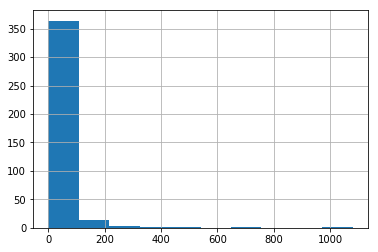

In [60]:
df_profile['likes_memes'].hist();

In [61]:
df_profile.to_csv('vk_data_profile.csv',sep='\t')

Есть ли uid среди членов группы.

In [63]:
hse_memes_ppl = [ ]

for offset in range(0, 53000, 1000):
    time.sleep(0.4)     
    cur_infa = vk_download('groups.getMembers', 'group_id=139105204&offset=' + str(offset))
    hse_memes_ppl.extend(cur_infa['response']['items'])

In [66]:
hse_memes_ppl = set(hse_memes_ppl)
len(hse_memes_ppl)

52236

In [68]:
df_profile['in_hse_memes_group'] = df_profile.uid.apply(lambda w: w in hse_memes_ppl)

In [69]:
df_profile.to_csv('vk_data_profile.csv',sep='\t')

In [71]:
df_profile['in_hse_memes_group'].mean()

0.7253521126760564